# Correlating transporter abundances to environmental data

## Overview

Here normalized transporter abundances are compared to the environmental data.

In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Functionality

In [2]:
def standardize(df):
    ts_stand = (df - df.mean()) / df.std()
    return ts_stand

In [3]:
def annotate_clustermap(ax,pvals,dec=1,minval=0.5):
    rows = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind].index
    cols = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind].columns
    # Extract reordered plotted data from ax
    data_norm = ax.data2d.loc[list(rows),list(cols)]
    # Reorder original data
    a = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind]
    p = pvals.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind]
    if dec == 0:
        a = a.astype(int)
    else:
        a = np.round(a,dec)
    for row in range(0,len(a.index)):
        for col in range(0,len(a.columns)):
            add = ""
            zval = data_norm.iloc[row,col]
            val = a.iloc[row,col]
            pval = p.iloc[row,col]
            textcol="white"
            if zval <=0.4 and zval>=-0.4: 
                textcol = "black"
            if val<=minval: continue
            if pval < 0.05:
                add = "*"
            ax.ax_heatmap.text(col+0.5,row+0.5,"{}{}".format(val,add),fontdict={'size':6,'color':textcol, 'horizontalalignment': 'center', 'verticalalignment': 'center'})
    return a,data_norm

In [4]:
cats = ["Anions","Cations","NH3 Nitrate","Urea","phosphate","phosphonate","AA peptide","nucleoside","carbohydrate"]
cat_cols = sns.color_palette("Paired", 6) + sns.color_palette("Dark2",4)[1:]
cat_lut = dict(zip(map(str,cats),cat_cols))
cat_lut["Other"] = "black"
cat_lut["Rare nutr"] = "grey"

In [5]:
meta = pd.read_csv("data/LMO.time.series.metadata.csv", header=0, sep="\t", index_col=0)
meta.rename(index = lambda x: str(x)[2:],inplace=True)
metavars = ["Temperature","Salinity","Chla","Nitrate","Phosphate","Silicate","Ammonium","DOC","TotalN"]

## Metagenome

In [6]:
mg_bac_trans = pd.read_table("results/mg/bac_select_trans.tpm.tsv", header=0, index_col=0)

In [7]:
meta_mg = meta.loc[mg_bac_trans.columns[4:],metavars]

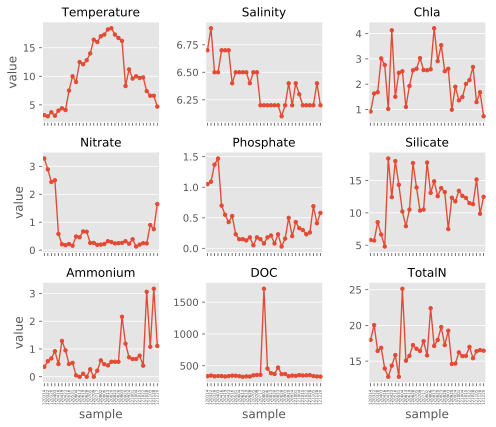

In [8]:
meta_mg_melt = meta_mg.copy(deep=True)
meta_mg_melt["sample"] = meta_mg.index
meta_mg_melt = pd.melt(meta_mg_melt,id_vars=["sample"])
ax = sns.factorplot(data=meta_mg_melt,x="sample",y="value",col="variable",col_wrap=3,sharey=False,size=2,scale=0.5, aspect=1.2)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=90,fontsize=4)
plt.subplots_adjust(wspace=0.4)

In [9]:
meta_mg.loc[meta_mg.DOC>400,"DOC"] = np.nan

In [10]:
meta_mg_stand = standardize(meta_mg)

In [11]:
mg_bac_stand = standardize(mg_bac_trans.groupby(level=0).sum())

### Correlate

In [12]:
mg_cordf = pd.merge(mg_bac_stand.T,meta_mg_stand,left_index=True,right_index=True)
mg_cor,mg_p = pd.DataFrame(spearmanr(mg_cordf)[0],columns=mg_cordf.columns,index=mg_cordf.columns),pd.DataFrame(spearmanr(mg_cordf)[1],columns=mg_cordf.columns,index=mg_cordf.columns)
mg_cor.drop(metavars,inplace=True)
mg_p.drop(metavars,inplace=True)
mg_cor.drop(mg_bac_stand.index,inplace=True,axis=1, errors="ignore")
mg_p.drop(mg_bac_stand.index,inplace=True,axis=1, errors="ignore")

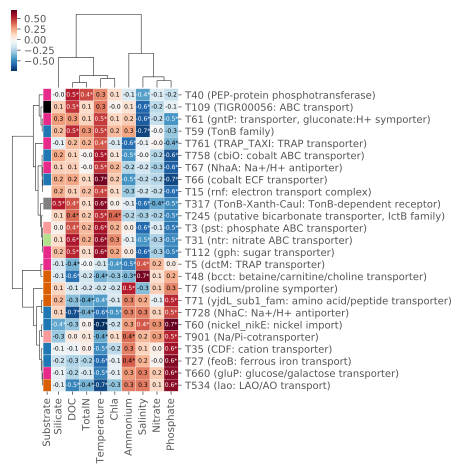

In [13]:
# Get significant transporters
mg_cor_sig = set(mg_p.loc[mg_p.min(axis=1)<0.05].index).intersection(set(mg_cor.loc[np.abs(mg_cor).groupby(level=0).max().max(axis=1)>=0.5].index))

# Assign row colors
row_cols = pd.Series([mg_bac_trans.loc[t,"substrate_category"] for t in mg_cor_sig],index=mg_cor_sig).map(cat_lut)
row_cols.name="Substrate"

mg_ax = sns.clustermap(mg_cor.loc[mg_cor_sig],figsize=(3,7),linewidths=0.2,method="complete",metric="correlation", 
                      row_colors=row_cols, cmap="RdBu_r")
annotate_clustermap(ax=mg_ax,pvals=mg_p.loc[mg_cor_sig], minval=-10,dec=1)
mg_ax.ax_heatmap.yaxis.set_ticklabels([item.get_text()+" ("+mg_bac_trans.loc[item.get_text(),"name"]+")" for item in mg_ax.ax_heatmap.yaxis.get_ticklabels()]);

plt.setp(mg_ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig("results/figures/mg_env_cor.png",dpi=300,bbox_inches="tight")

## Metatranscriptome

In [14]:
mt_bac_trans = pd.read_table("results/mt/bac_select_trans.tpm.tsv", header=0, index_col=0)

In [15]:
meta_mt = meta.loc[mt_bac_trans.columns[4:],metavars]

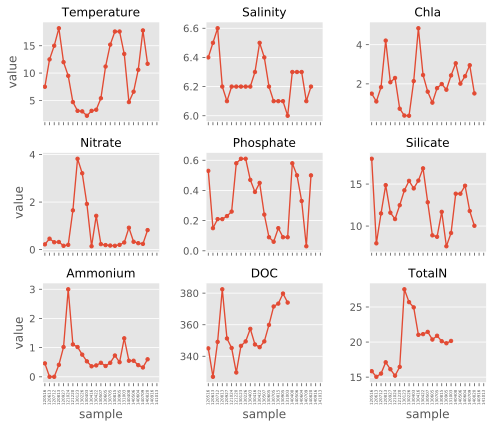

In [16]:
meta_mt_melt = meta_mt.copy(deep=True)
meta_mt_melt["sample"] = meta_mt.index
meta_mt_melt = pd.melt(meta_mt_melt,id_vars=["sample"])
ax = sns.factorplot(data=meta_mt_melt,x="sample",y="value",col="variable",col_wrap=3,sharey=False,size=2,scale=0.5, aspect=1.2)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=90,fontsize=4)
plt.subplots_adjust(wspace=0.4)

In [17]:
meta_mt_stand = standardize(meta_mt)

In [18]:
mt_bac_stand = standardize(mt_bac_trans.groupby(level=0).sum())

### Correlate

In [19]:
mt_cordf = pd.merge(mt_bac_stand.T,meta_mt_stand,left_index=True,right_index=True)
mt_cor,mt_p = pd.DataFrame(spearmanr(mt_cordf)[0],columns=mt_cordf.columns,index=mt_cordf.columns),pd.DataFrame(spearmanr(mt_cordf)[1],columns=mt_cordf.columns,index=mt_cordf.columns)
mt_cor.drop(metavars,inplace=True)
mt_p.drop(metavars,inplace=True)
mt_cor.drop(mt_bac_stand.index,inplace=True,axis=1, errors="ignore")
mt_p.drop(mt_bac_stand.index,inplace=True,axis=1, errors="ignore")

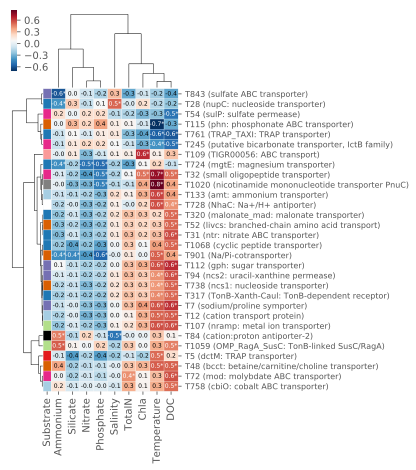

In [20]:
# Get significant transporters
mt_cor_sig = set(mt_p.loc[mt_p.min(axis=1)<0.05].index).intersection(set(mt_cor.loc[np.abs(mt_cor).groupby(level=0).max().max(axis=1)>=0.5].index))

# Assign row colors
row_cols = pd.Series([mt_bac_trans.loc[t,"substrate_category"] for t in mt_cor_sig],index=mt_cor_sig).map(cat_lut)
row_cols.name="Substrate"

mt_ax = sns.clustermap(mt_cor.loc[mt_cor_sig],figsize=(3,7),linewidths=0.2,method="complete",metric="correlation", 
                      row_colors=row_cols, cmap="RdBu_r")
annotate_clustermap(ax=mt_ax,pvals=mt_p.loc[mt_cor_sig], minval=-10,dec=1)
#mt_ax.ax_heatmap.yaxis.set_ticklabels([item.get_text()+" ("+mt_bac_trans.loc[item.get_text(),"name"]+")" for item in mt_ax.ax_heatmap.yaxis.get_ticklabels()]);

# Change transporter labels to include the second category substrate
ticklocs = []
ticklabels = []
for i,item in enumerate(mt_cor.loc[mt_cor_sig].index):
    ticklocs.append(i+0.5)
    ticklabels.append("{} ({})".format(item,mt_bac_trans.loc[item,"name"]))
mt_ax.ax_heatmap.yaxis.set_ticks(ticklocs)
mt_ax.ax_heatmap.yaxis.set_ticklabels(ticklabels,fontsize=8);

plt.setp(mt_ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig("results/figures/mt_env_cor.png",dpi=300,bbox_inches="tight")